# MAPS model choices
Explore options for modeling the proportions of singletons against mutability. 

## Preliminaries

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# Imports
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import statsmodels.api as sm

from src.constraint import maps
from src import constants as C
from src import visualisation as vis

In [3]:
# Plotting styles and colors
plt.style.use(C.STYLE_DEFAULT)
palette = vis.color_palette()

In [4]:
# Get PS in synonymous contexts
syn = pd.read_csv(C.PS_SYN_CONTEXT, sep="\t")

# Drop synonymous contexts with no singletons
syn = syn.query("n_singletons > 0")
print(f"Synonymous contexts with at least one singleton variant: {len(syn)}")

# Get synonymous variants in CpG and non-CpG contexts
syn_non = syn[syn.variant_type != "CpG"].copy()
syn_cpg = syn[syn.variant_type == "CpG"].copy()

Synonymous contexts with at least one singleton variant: 258


In [5]:
# Get PS by consequence and CpG status
non = pd.read_csv(C.PS_REGIONS_NON_CPG, sep="\t")
cpg = pd.read_csv(C.PS_REGIONS_CPG, sep="\t")
joint = pd.read_csv(C.PS_REGIONS, sep="\t")

## Exploratory analysis

Below we plot the relationship between proportion of singletons and mutability.

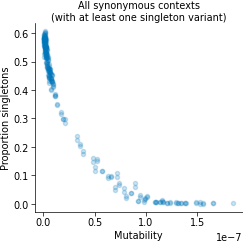

In [6]:
# Plot singletons vs mutability
x = syn["mu"]
y = syn["ps"]

fig, ax = plt.subplots(1, 1, figsize=(2.5, 2.5), layout="constrained")

def plot_ps_vs_mu(x, y, ax = ax, **kwargs):
    """Plot proportion of singletons vs mutability."""

    ax.scatter(x, y, alpha=0.2, marker="o")
    ax.set_xlabel("Mutability")
    ax.set_ylabel("Proportion singletons")
    ax.set_title("All synonymous contexts\n(with at least one singleton variant)")

    return ax

plot_ps_vs_mu(x,y);


The relationship is slightly more linear after log transformation... 

Text(0.5, 1.0, 'All synonymous contexts\n(with at least one singleton variant)')

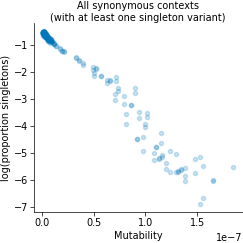

In [7]:
# Linearise the data
fig, ax = plt.subplots(1, 1, figsize=(2.5, 2.5), layout="constrained")

ax.scatter(x, np.log(y), alpha=0.2, marker="o")
ax.set_xlabel("Mutability")
ax.set_ylabel("log(proportion singletons)")
ax.set_title("All synonymous contexts\n(with at least one singleton variant)")


And again not quite linear after square-root transformation.

Text(0.5, 1.0, 'All synonymous contexts\n(with at least one singleton variant)')

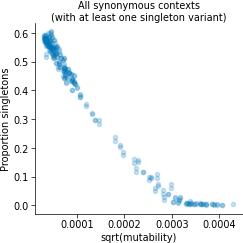

In [8]:
fig, ax = plt.subplots(1, 1, figsize=(2.5, 2.5), layout="constrained")
ax.scatter(np.sqrt(x), y, alpha=0.2, marker="o")
ax.set_xlabel("sqrt(mutability)")
ax.set_ylabel("Proportion singletons")
ax.set_title("All synonymous contexts\n(with at least one singleton variant)")


It is not straightforward to linearise the data.

## Modelling CpGs and non-CpGs jointly

### Linear model of log(PS) vs mu

A log transformation of PS nearly linearises the data. How does a WLS model built on this transformed data perform across all synonymous contexts?

In [9]:
# Fit a polynomial equation to log(PS) vs mu
p = maps.maps_model(syn.mu, np.log(syn.ps), syn.n_obs, deg=1)

syn["fit_ps"] = p(syn.mu)

In [10]:
# Get model statistics
model = sm.WLS(
    syn.ps,
    sm.tools.add_constant(np.exp(syn.fit_ps)),
    weights=syn.n_obs,
)
results = model.fit()
results.summary(slim=True)

<class 'statsmodels.iolib.summary.Summary'>
"""
                            WLS Regression Results                            
==============================================================================
Dep. Variable:                     ps   R-squared:                       0.983
Model:                            WLS   Adj. R-squared:                  0.983
No. Observations:                 258   F-statistic:                 1.496e+04
Covariance Type:            nonrobust   Prob (F-statistic):          4.11e-229
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0107      0.004      2.946      0.004       0.004       0.018
fit_ps         0.9732      0.008    122.320      0.000       0.957       0.989
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

A linear model fits the data well. But the fitted values do not closely match the observed values. Especially for CpG contexts.

Text(0, 0.5, 'Fitted proportion of singletons')

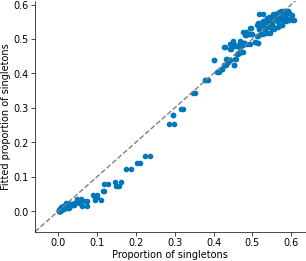

In [11]:
# Plot the data
fig, ax = plt.subplots(1,1)

# Non-CpGs
ax.scatter(x=syn.ps, y=np.exp(syn.fit_ps))

ax.axline(
    (min(ax.get_xlim()), min(ax.get_xlim())),
    slope=1,
    color="grey",
    linestyle="--",
)
ax.set_xlabel("Proportion of singletons")
ax.set_ylabel("Fitted proportion of singletons")

The MAPS scores show that this model generally under-predicts the proportion of singletons.

In [12]:
maps.maps(p, joint, transform="log_ps")

,csq,mu,n_singletons,n_obs,ps,ps_pred,maps,se,ci95
0,missense_variant,1.320782e-08,5958613,12358828,0.482134,0.352592,0.129542,0.000142,0.000279
1,stop_gained,1.749916e-08,238811,425204,0.561639,0.296311,0.265328,0.000761,0.001491
2,synonymous_variant,1.509552e-08,2412504,5579026,0.432424,0.326626,0.105798,0.000210,0.000411
3,distal_nmd,1.557515e-08,54382,101427,0.536169,0.320338,0.215830,0.001566,0.003069
4,long_exon,1.479470e-08,15857,26309,0.602722,0.330632,0.272090,0.003017,0.005913
5,nmd_target,1.934344e-08,145625,256243,0.568308,0.274973,0.293335,0.000978,0.001918
6,start_proximal,1.249526e-08,22947,41225,0.556628,0.362922,0.193707,0.002447,0.004796


### Polynomial equation for PS vs mu

A second degree polynomial does well for PS vs mu in CpG contexts. Could this approach be appplied to the whole dataset?

In [13]:
# Fit a polynomial equation to PS vs mu
p = maps.maps_model(syn.mu, syn.ps, syn.n_obs, deg=2)

syn["fit_ps"] = p(syn.mu)

The model performs reasonably well...

In [14]:
# Get model statistics
model = sm.WLS(
    syn.ps,
    sm.tools.add_constant(syn.fit_ps),
    weights=syn.n_obs,
)
results = model.fit()
results.summary(slim=True)

<class 'statsmodels.iolib.summary.Summary'>
"""
                            WLS Regression Results                            
==============================================================================
Dep. Variable:                     ps   R-squared:                       0.954
Model:                            WLS   Adj. R-squared:                  0.954
No. Observations:                 258   F-statistic:                     5319.
Covariance Type:            nonrobust   Prob (F-statistic):          2.77e-173
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0051      0.006      0.822      0.412      -0.007       0.017
fit_ps         1.0025      0.014     72.932      0.000       0.975       1.030
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

But again, the fitted values do not tally with the observed values.

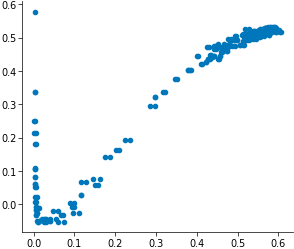

In [15]:
fig, ax = plt.subplots(1,1)
ax.scatter(syn.ps, syn.fit_ps)

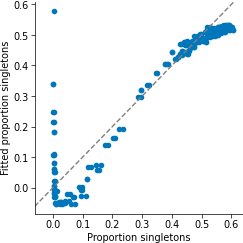

In [16]:
# Plot the fitted vs observed data
fig, ax = plt.subplots(1,1,figsize=(2.5, 2.5), layout="constrained")
ax.scatter(x = syn.ps, y = syn.fit_ps)
ax.set_xlabel("Proportion singletons")
ax.set_ylabel("Fitted proportion singletons")
ax.axline(
    (min(ax.get_xlim()), min(ax.get_xlim())), slope=1, color="grey", linestyle="--"
);

And, as seen in MAPS scores, this model under-estimates the proportion of singletons.

In [17]:
maps.maps(p, joint)

,csq,mu,n_singletons,n_obs,ps,ps_pred,maps,se,ci95
0,missense_variant,1.320782e-08,5958613,12358828,0.482134,0.382837,0.099297,0.000142,0.000279
1,stop_gained,1.749916e-08,238811,425204,0.561639,0.336168,0.225471,0.000761,0.001491
2,synonymous_variant,1.509552e-08,2412504,5579026,0.432424,0.361982,0.070442,0.000210,0.000411
3,distal_nmd,1.557515e-08,54382,101427,0.536169,0.356765,0.179404,0.001566,0.003069
4,long_exon,1.479470e-08,15857,26309,0.602722,0.365271,0.237450,0.003017,0.005913
5,nmd_target,1.934344e-08,145625,256243,0.568308,0.316922,0.251386,0.000978,0.001918
6,start_proximal,1.249526e-08,22947,41225,0.556628,0.390842,0.165786,0.002447,0.004796


### Polynomial equation for PS vs sqrt(mu)
What about with a square-root transformation of mu?

In [18]:
p = maps.maps_model(np.sqrt(syn.mu), syn.ps, syn.n_obs, deg=1)

syn["fit_ps"] = p(np.sqrt(syn.mu))

In [19]:
# Get model statistics
model = sm.WLS(
    syn.ps,
    sm.tools.add_constant(syn.fit_ps),
    weights=syn.n_obs,
)
results = model.fit()
results.summary(slim=True)

<class 'statsmodels.iolib.summary.Summary'>
"""
                            WLS Regression Results                            
==============================================================================
Dep. Variable:                     ps   R-squared:                       0.965
Model:                            WLS   Adj. R-squared:                  0.965
No. Observations:                 258   F-statistic:                     7117.
Covariance Type:            nonrobust   Prob (F-statistic):          7.92e-189
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0021      0.005     -0.389      0.698      -0.013       0.009
fit_ps         1.0142      0.012     84.364      0.000       0.991       1.038
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

There observed and fitted values do not match well, especially for more mutable contexts.

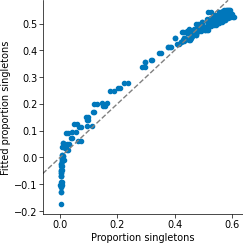

In [20]:
# Plot the fitted vs observed data
fig, ax = plt.subplots(1,1,figsize=(2.5, 2.5), layout="constrained")
ax.scatter(x = syn.ps, y = syn.fit_ps)
ax.set_xlabel("Proportion singletons")
ax.set_ylabel("Fitted proportion singletons")
ax.axline(
    (min(ax.get_xlim()), min(ax.get_xlim())), slope=1, color="grey", linestyle="--"
);

This is reflected in the MAPS scores. Again the model generally under-predicts the proportion of singletons. 

In [21]:
maps.maps(p, joint, transform="sqrt_mu")

,csq,mu,n_singletons,n_obs,ps,ps_pred,maps,se,ci95
0,missense_variant,1.320782e-08,5958613,12358828,0.482134,0.396364,0.085771,0.000142,0.000279
1,stop_gained,1.749916e-08,238811,425204,0.561639,0.364926,0.196713,0.000761,0.001491
2,synonymous_variant,1.509552e-08,2412504,5579026,0.432424,0.381987,0.050437,0.000210,0.000411
3,distal_nmd,1.557515e-08,54382,101427,0.536169,0.378479,0.157690,0.001566,0.003069
4,long_exon,1.479470e-08,15857,26309,0.602722,0.384215,0.218507,0.003017,0.005913
5,nmd_target,1.934344e-08,145625,256243,0.568308,0.352617,0.215691,0.000978,0.001918
6,start_proximal,1.249526e-08,22947,41225,0.556628,0.402056,0.154573,0.002447,0.004796


## Modelling CpG and non-CpG contexts separately
One option is to model CpG and non-CpG contexts separately.

### Non-CpGs

Below we plot PS vs mu for non-CpG variants.

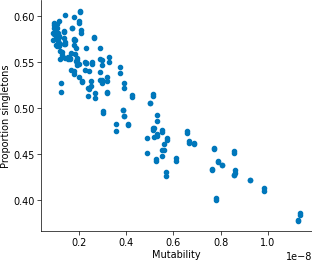

In [22]:
# Plot proportion of singletons vs mutability for non-CpG sites
fig, ax = plt.subplots(1,1)
ax.scatter(x = syn_non.mu, y = syn_non.ps)
ax.set_xlabel("Mutability")
ax.set_ylabel("Proportion singletons");

The relationship is not quite linear, but it is made more so by a square root transformation of mu, as shown below.

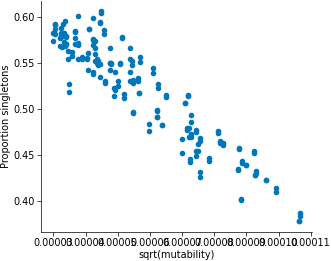

In [23]:
# Plot proportion of singletons vs sqrt(mu) for non-CpG sites
fig, ax = plt.subplots(1,1)
ax.scatter(x = np.sqrt(syn_non.mu), y = syn_non.ps)
ax.set_ylabel("Proportion singletons")
ax.set_xlabel("sqrt(mutability)");

How does a model built on PS vs sqrt(mu) perform?

In [24]:
# Fit a linear regression to PS vs sqrt(mu) for non-CpGs
p = maps.maps_model(np.sqrt(syn_non.mu), syn_non.ps, syn_non.n_obs, deg=1)

syn_non["fit_ps"] = p(np.sqrt(syn_non.mu))

The model performs well. 

In [25]:
# Get model statistics
model = sm.WLS(
    syn_non.ps,
    sm.tools.add_constant(syn_non.fit_ps),
    weights=syn_non.n_obs,
)
results = model.fit()
results.summary(slim=True)

<class 'statsmodels.iolib.summary.Summary'>
"""
                            WLS Regression Results                            
==============================================================================
Dep. Variable:                     ps   R-squared:                       0.897
Model:                            WLS   Adj. R-squared:                  0.897
No. Observations:                 176   F-statistic:                     1519.
Covariance Type:            nonrobust   Prob (F-statistic):           6.99e-88
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0153      0.013     -1.211      0.228      -0.040       0.010
fit_ps         1.0312      0.026     38.971      0.000       0.979       1.083
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

There is a good linear fit between observed and fitted values.

Text(0, 0.5, 'Fitted proportion of singletons')

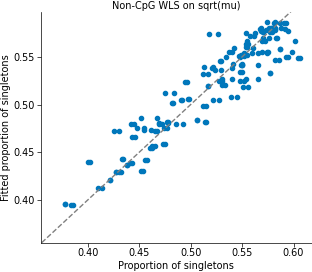

In [26]:
# Plot the data
fig, ax = plt.subplots(1,1)

# Non-CpGs
ax.scatter(x=syn_non.ps, y=syn_non.fit_ps)

ax.axline(
    (min(ax.get_xlim()), min(ax.get_xlim())),
    slope=1,
    color="grey",
    linestyle="--",
)
ax.set_title("Non-CpG WLS on sqrt(mu)")
ax.set_xlabel("Proportion of singletons")
ax.set_ylabel("Fitted proportion of singletons")

These MAPS scores are much closer to the expected values.

In [27]:
maps.maps(p, non, transform="sqrt_mu")

,csq,mu,n_singletons,n_obs,ps,ps_pred,maps,se,ci95
0,missense_variant,4.871762e-09,5683353,10892579,0.521764,0.486613,0.035150,0.000151,0.000297
1,stop_gained,4.816411e-09,224279,362603,0.618525,0.487608,0.130917,0.000807,0.001581
2,synonymous_variant,5.858479e-09,2294097,4823691,0.475590,0.469756,0.005834,0.000227,0.000446
3,distal_nmd,4.714853e-09,52043,89088,0.584175,0.489447,0.094729,0.001651,0.003236
4,long_exon,4.670412e-09,14717,22831,0.644606,0.490258,0.154348,0.003168,0.006209
5,nmd_target,4.845097e-09,136140,214602,0.634384,0.487092,0.147292,0.001040,0.002038
6,start_proximal,4.988926e-09,21379,36082,0.592512,0.484527,0.107984,0.002587,0.005070


### CpGs

Can we fit a polynomial to the CpG data with either:
- no transformations
- log-transformation of PS
- sqrt-transformation of mu?

#### No transformations, linear model

In [28]:
# Fit a linear regression to PS vs mu for CpG contexts
p = maps.maps_model(syn_cpg.mu, syn_cpg.ps, syn_cpg.n_obs, deg=1)

syn_cpg["fit_ps"] = p(syn_cpg.mu)

The model performs well. 

In [29]:
# Get model statistics
model = sm.WLS(
    syn_cpg.ps,
    sm.tools.add_constant(syn_cpg.fit_ps),
    weights=syn_cpg.n_obs,
)
results = model.fit()
results.summary(slim=True)

<class 'statsmodels.iolib.summary.Summary'>
"""
                            WLS Regression Results                            
==============================================================================
Dep. Variable:                     ps   R-squared:                       0.907
Model:                            WLS   Adj. R-squared:                  0.905
No. Observations:                  82   F-statistic:                     776.2
Covariance Type:            nonrobust   Prob (F-statistic):           6.18e-43
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0014      0.005      0.271      0.787      -0.009       0.012
fit_ps         0.9735      0.035     27.860      0.000       0.904       1.043
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

There is a good linear fit between observed and fitted values.

There is a poor correspondence between observed and fitted values

Text(0, 0.5, 'Fitted proportion of singletons')

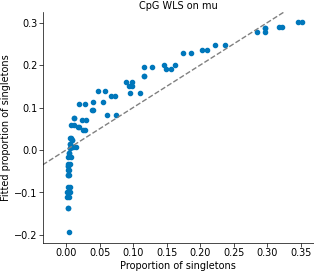

In [30]:
# Plot the data
fig, ax = plt.subplots(1,1)

# Non-CpGs
ax.scatter(x=syn_cpg.ps, y=syn_cpg.fit_ps)

ax.axline(
    (min(ax.get_xlim()), min(ax.get_xlim())),
    slope=1,
    color="grey",
    linestyle="--",
)
ax.set_title("CpG WLS on mu")
ax.set_xlabel("Proportion of singletons")
ax.set_ylabel("Fitted proportion of singletons")

Strikingly, MAPS scores are very close to the expected values.

In [31]:
maps.maps(p, cpg,)

,csq,mu,n_singletons,n_obs,ps,ps_pred,maps,se,ci95
0,missense_variant,9.372442e-08,110411,1130579,0.097659,0.070161,0.027498,0.000279,0.000547
1,stop_gained,1.069883e-07,7999,51137,0.156423,0.031797,0.124626,0.001606,0.003148
2,synonymous_variant,8.927054e-08,50868,603290,0.084318,0.083044,0.001274,0.000358,0.000701
3,distal_nmd,1.073427e-07,1257,10520,0.119487,0.030772,0.088715,0.003162,0.006198
4,long_exon,1.045281e-07,557,2543,0.219033,0.038913,0.180120,0.008202,0.016075
5,nmd_target,1.095155e-07,5429,34351,0.158045,0.024487,0.133558,0.001968,0.003858
6,start_proximal,8.434951e-08,756,3723,0.203062,0.097277,0.105785,0.006593,0.012922


#### No transformations, polynomial model

In [32]:
# Fit a polynomial regression to PS vs mu for CpG contexts
p = maps.maps_model(syn_cpg.mu, syn_cpg.ps, syn_cpg.n_obs, deg=2)

syn_cpg["fit_ps"] = p(syn_cpg.mu)

The model performs well. 

In [33]:
# Get model statistics
model = sm.WLS(
    syn_cpg.ps,
    sm.tools.add_constant(syn_cpg.fit_ps),
    weights=syn_cpg.n_obs,
)
results = model.fit()
results.summary(slim=True)

<class 'statsmodels.iolib.summary.Summary'>
"""
                            WLS Regression Results                            
==============================================================================
Dep. Variable:                     ps   R-squared:                       0.993
Model:                            WLS   Adj. R-squared:                  0.993
No. Observations:                  82   F-statistic:                 1.196e+04
Covariance Type:            nonrobust   Prob (F-statistic):           7.15e-89
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0006      0.001     -0.462      0.645      -0.003       0.002
fit_ps         1.0050      0.009    109.345      0.000       0.987       1.023
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

There is a much better linear fit between observed and fitted values.

Text(0, 0.5, 'Fitted proportion of singletons')

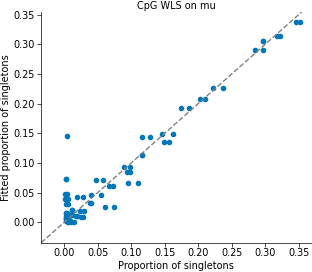

In [34]:
# Plot the data
fig, ax = plt.subplots(1,1)

# Non-CpGs
ax.scatter(x=syn_cpg.ps, y=syn_cpg.fit_ps)

ax.axline(
    (min(ax.get_xlim()), min(ax.get_xlim())),
    slope=1,
    color="grey",
    linestyle="--",
)
ax.set_title("CpG WLS on mu")
ax.set_xlabel("Proportion of singletons")
ax.set_ylabel("Fitted proportion of singletons")

However, MAPS scores are off, and imply that the model under-estimates the proportion of singletons.

In [35]:
maps.maps(p, cpg,)

,csq,mu,n_singletons,n_obs,ps,ps_pred,maps,se,ci95
0,missense_variant,9.372442e-08,110411,1130579,0.097659,0.018724,0.078935,0.000279,0.000547
1,stop_gained,1.069883e-07,7999,51137,0.156423,0.004603,0.151820,0.001606,0.003148
2,synonymous_variant,8.927054e-08,50868,603290,0.084318,0.025943,0.058375,0.000358,0.000701
3,distal_nmd,1.073427e-07,1257,10520,0.119487,0.004377,0.115110,0.003162,0.006198
4,long_exon,1.045281e-07,557,2543,0.219033,0.006388,0.212645,0.008202,0.016075
5,nmd_target,1.095155e-07,5429,34351,0.158045,0.003165,0.154880,0.001968,0.003858
6,start_proximal,8.434951e-08,756,3723,0.203062,0.035367,0.167695,0.006593,0.012922


#### Log transformation of PS, linear model

In [36]:
# Fit a linear regression to log(PS) vs mu for CpG contexts
p = maps.maps_model(syn_cpg.mu, np.log(syn_cpg.ps), syn_cpg.n_obs, deg=1)

syn_cpg["fit_ps"] = np.exp(p(syn_cpg.mu))

The model performs well. 

In [37]:
# Get model statistics
model = sm.WLS(
    syn_cpg.ps,
    sm.tools.add_constant(syn_cpg.fit_ps),
    weights=syn_cpg.n_obs,
)
results = model.fit()
results.summary(slim=True)

<class 'statsmodels.iolib.summary.Summary'>
"""
                            WLS Regression Results                            
==============================================================================
Dep. Variable:                     ps   R-squared:                       0.979
Model:                            WLS   Adj. R-squared:                  0.979
No. Observations:                  82   F-statistic:                     3697.
Covariance Type:            nonrobust   Prob (F-statistic):           9.85e-69
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0055      0.002      2.265      0.026       0.001       0.010
fit_ps         1.0494      0.017     60.799      0.000       1.015       1.084
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

There is a poor fit between observed and fitted values.

Text(0, 0.5, 'Fitted proportion of singletons')

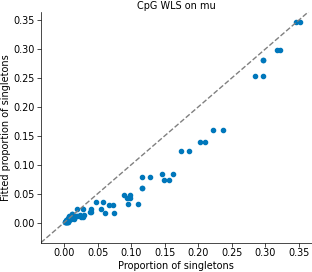

In [38]:
# Plot the data
fig, ax = plt.subplots(1,1)

# Non-CpGs
ax.scatter(x=syn_cpg.ps, y=syn_cpg.fit_ps)

ax.axline(
    (min(ax.get_xlim()), min(ax.get_xlim())),
    slope=1,
    color="grey",
    linestyle="--",
)
ax.set_title("CpG WLS on mu")
ax.set_xlabel("Proportion of singletons")
ax.set_ylabel("Fitted proportion of singletons")

And MAPS scores are off, implying that the model under-estimates the proportion of singletons.

In [39]:
maps.maps(p, cpg, transform="log_ps")

,csq,mu,n_singletons,n_obs,ps,ps_pred,maps,se,ci95
0,missense_variant,9.372442e-08,110411,1130579,0.097659,0.013461,0.084198,0.000279,0.000547
1,stop_gained,1.069883e-07,7999,51137,0.156423,0.007849,0.148574,0.001606,0.003148
2,synonymous_variant,8.927054e-08,50868,603290,0.084318,0.016134,0.068184,0.000358,0.000701
3,distal_nmd,1.073427e-07,1257,10520,0.119487,0.007737,0.111750,0.003162,0.006198
4,long_exon,1.045281e-07,557,2543,0.219033,0.008675,0.210358,0.008202,0.016075
5,nmd_target,1.095155e-07,5429,34351,0.158045,0.007082,0.150963,0.001968,0.003858
6,start_proximal,8.434951e-08,756,3723,0.203062,0.019708,0.183354,0.006593,0.012922


#### Log transformation of PS, polynomial model

In [40]:
# Fit a polynomial regression to log(PS) vs mu for CpG contexts
p = maps.maps_model(syn_cpg.mu, np.log(syn_cpg.ps), syn_cpg.n_obs, deg=2)

syn_cpg["fit_ps"] = np.exp(p(syn_cpg.mu))

The model performs well. 

In [41]:
# Get model statistics
model = sm.WLS(
    syn_cpg.ps,
    sm.tools.add_constant(syn_cpg.fit_ps),
    weights=syn_cpg.n_obs,
)
results = model.fit()
results.summary(slim=True)

<class 'statsmodels.iolib.summary.Summary'>
"""
                            WLS Regression Results                            
==============================================================================
Dep. Variable:                     ps   R-squared:                       0.967
Model:                            WLS   Adj. R-squared:                  0.966
No. Observations:                  82   F-statistic:                     2316.
Covariance Type:            nonrobust   Prob (F-statistic):           8.01e-61
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0082      0.003      2.710      0.008       0.002       0.014
fit_ps         0.9765      0.020     48.120      0.000       0.936       1.017
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

There is again a poor fit between observed and fitted values.

Text(0, 0.5, 'Fitted proportion of singletons')

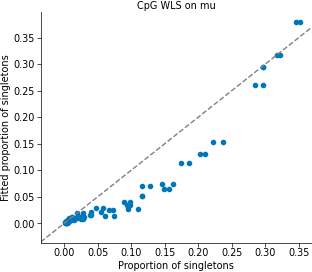

In [42]:
# Plot the data
fig, ax = plt.subplots(1,1)

# Non-CpGs
ax.scatter(x=syn_cpg.ps, y=syn_cpg.fit_ps)

ax.axline(
    (min(ax.get_xlim()), min(ax.get_xlim())),
    slope=1,
    color="grey",
    linestyle="--",
)
ax.set_title("CpG WLS on mu")
ax.set_xlabel("Proportion of singletons")
ax.set_ylabel("Fitted proportion of singletons")

And MAPS scores are off, implying that the model under-estimates the proportion of singletons.

In [43]:
maps.maps(p, cpg, transform="log_ps")

,csq,mu,n_singletons,n_obs,ps,ps_pred,maps,se,ci95
0,missense_variant,9.372442e-08,110411,1130579,0.097659,0.011852,0.085807,0.000279,0.000547
1,stop_gained,1.069883e-07,7999,51137,0.156423,0.007338,0.149085,0.001606,0.003148
2,synonymous_variant,8.927054e-08,50868,603290,0.084318,0.014008,0.070310,0.000358,0.000701
3,distal_nmd,1.073427e-07,1257,10520,0.119487,0.007247,0.112239,0.003162,0.006198
4,long_exon,1.045281e-07,557,2543,0.219033,0.008004,0.211029,0.008202,0.016075
5,nmd_target,1.095155e-07,5429,34351,0.158045,0.006718,0.151327,0.001968,0.003858
6,start_proximal,8.434951e-08,756,3723,0.203062,0.016909,0.186153,0.006593,0.012922


#### Square root transformation of mu, linear model

In [44]:
# Fit a linear regression to log(PS) vs mu for CpG contexts
p = maps.maps_model(np.sqrt(syn_cpg.mu), syn_cpg.ps, syn_cpg.n_obs, deg=1)

syn_cpg["fit_ps"] = p(np.sqrt(syn_cpg.mu))

The model performs well. 

In [45]:
# Get model statistics
model = sm.WLS(
    syn_cpg.ps,
    sm.tools.add_constant(syn_cpg.fit_ps),
    weights=syn_cpg.n_obs,
)
results = model.fit()
results.summary(slim=True)

<class 'statsmodels.iolib.summary.Summary'>
"""
                            WLS Regression Results                            
==============================================================================
Dep. Variable:                     ps   R-squared:                       0.958
Model:                            WLS   Adj. R-squared:                  0.957
No. Observations:                  82   F-statistic:                     1821.
Covariance Type:            nonrobust   Prob (F-statistic):           8.29e-57
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0006      0.004      0.168      0.867      -0.006       0.008
fit_ps         0.9921      0.023     42.678      0.000       0.946       1.038
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

There is a poor fit between observed and fitted values.

Text(0, 0.5, 'Fitted proportion of singletons')

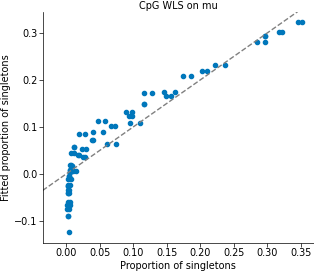

In [46]:
# Plot the data
fig, ax = plt.subplots(1,1)

# Non-CpGs
ax.scatter(x=syn_cpg.ps, y=syn_cpg.fit_ps)

ax.axline(
    (min(ax.get_xlim()), min(ax.get_xlim())),
    slope=1,
    color="grey",
    linestyle="--",
)
ax.set_title("CpG WLS on mu")
ax.set_xlabel("Proportion of singletons")
ax.set_ylabel("Fitted proportion of singletons")

And MAPS scores are slightly off, implying that the model under-estimates the proportion of singletons.

In [47]:
maps.maps(p, cpg, transform="sqrt_mu")

,csq,mu,n_singletons,n_obs,ps,ps_pred,maps,se,ci95
0,missense_variant,9.372442e-08,110411,1130579,0.097659,0.053455,0.044204,0.000279,0.000547
1,stop_gained,1.069883e-07,7999,51137,0.156423,0.023494,0.132929,0.001606,0.003148
2,synonymous_variant,8.927054e-08,50868,603290,0.084318,0.063987,0.020331,0.000358,0.000701
3,distal_nmd,1.073427e-07,1257,10520,0.119487,0.022719,0.096767,0.003162,0.006198
4,long_exon,1.045281e-07,557,2543,0.219033,0.028904,0.190128,0.008202,0.016075
5,nmd_target,1.095155e-07,5429,34351,0.158045,0.018000,0.140045,0.001968,0.003858
6,start_proximal,8.434951e-08,756,3723,0.203062,0.075933,0.127129,0.006593,0.012922


#### Square-root transformation of mu, polynomial model

In [48]:
# Fit a polynomial regression to PS vs sqrt(mu) for CpG contexts
p = maps.maps_model(np.sqrt(syn_cpg.mu), syn_cpg.ps, syn_cpg.n_obs, deg=2)

syn_cpg["fit_ps"] = p(np.sqrt(syn_cpg.mu))

The model performs well. 

In [49]:
# Get model statistics
model = sm.WLS(
    syn_cpg.ps,
    sm.tools.add_constant(syn_cpg.fit_ps),
    weights=syn_cpg.n_obs,
)
results = model.fit()
results.summary(slim=True)

<class 'statsmodels.iolib.summary.Summary'>
"""
                            WLS Regression Results                            
==============================================================================
Dep. Variable:                     ps   R-squared:                       0.991
Model:                            WLS   Adj. R-squared:                  0.991
No. Observations:                  82   F-statistic:                     8942.
Covariance Type:            nonrobust   Prob (F-statistic):           7.27e-84
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0025      0.002      1.587      0.116      -0.001       0.006
fit_ps         1.0103      0.011     94.564      0.000       0.989       1.032
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

There is a reasonable fit between observed and fitted values.

Text(0, 0.5, 'Fitted proportion of singletons')

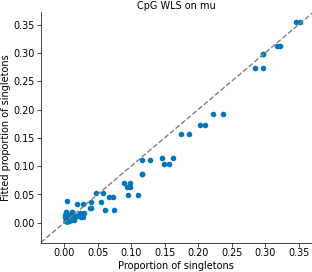

In [50]:
# Plot the data
fig, ax = plt.subplots(1,1)

# Non-CpGs
ax.scatter(x=syn_cpg.ps, y=syn_cpg.fit_ps)

ax.axline(
    (min(ax.get_xlim()), min(ax.get_xlim())),
    slope=1,
    color="grey",
    linestyle="--",
)
ax.set_title("CpG WLS on mu")
ax.set_xlabel("Proportion of singletons")
ax.set_ylabel("Fitted proportion of singletons")

And MAPS scores are slightly off, implying that the model under-estimates the proportion of singletons.

In [51]:
maps.maps(p, cpg, transform="sqrt_mu")

,csq,mu,n_singletons,n_obs,ps,ps_pred,maps,se,ci95
0,missense_variant,9.372442e-08,110411,1130579,0.097659,0.017443,0.080216,0.000279,0.000547
1,stop_gained,1.069883e-07,7999,51137,0.156423,0.007494,0.148929,0.001606,0.003148
2,synonymous_variant,8.927054e-08,50868,603290,0.084318,0.022245,0.062073,0.000358,0.000701
3,distal_nmd,1.073427e-07,1257,10520,0.119487,0.007310,0.112177,0.003162,0.006198
4,long_exon,1.045281e-07,557,2543,0.219033,0.008884,0.210148,0.008202,0.016075
5,nmd_target,1.095155e-07,5429,34351,0.158045,0.006266,0.151779,0.001968,0.003858
6,start_proximal,8.434951e-08,756,3723,0.203062,0.028513,0.174549,0.006593,0.012922


## Conclusions

For now, let's try calculating MAPS for CpGs and non-CpGs separately. For both non-CpGs and CpGs, I will use a linear model of PS vs sqrt(mu).
We will see how it performs in practice.